# Housekeeping

In [1]:
if False:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

## Library Imports

In [2]:
# Core Libraries
import pandas as pd
from colorama import Fore, Style
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import set_config
import re
import json

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Model Interpretability
from sklearn.metrics import mean_squared_error, r2_score
from supertree import SuperTree

# Custom Functions
from functions import set_global_seeds, MASTER_SEED
from functions import plot_residuals_analysis, plot_model_comparison_heatmap
from functions import plot_prediction_intervals, plot_learning_curves

## Settings

In [3]:
warnings.filterwarnings("ignore")
set_config(transform_output="pandas")
print(Style.RESET_ALL)
# Set global random seeds for reproducibility
set_global_seeds(MASTER_SEED)


Global seeds set to 3004


## Import of variables from previous notebooks



In [4]:
with open('processed_data/model_results.json', 'r') as f:
    model_results = json.load(f)

%store -r X_train_genus
%store -r X_test_genus
%store -r Y_train
%store -r Y_test

#  Comparison of models

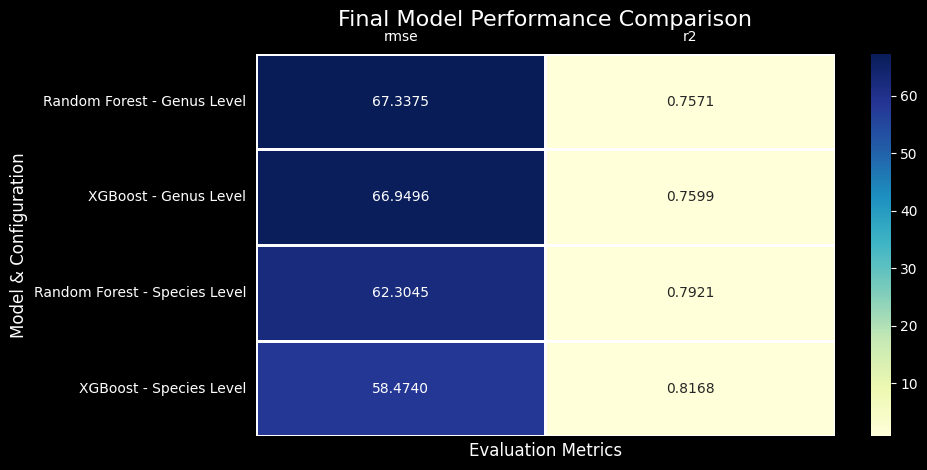

In [5]:
plot_model_comparison_heatmap(model_results, title="Final Model Performance Comparison")

## Base Visualisations

### Training the best model

In [6]:
rf_params = model_results[0]['best_params']
best_rf = RandomForestRegressor(
    **rf_params,
    random_state=MASTER_SEED,
    n_jobs=-1
)

best_rf.fit(X_train_genus, Y_train)
yhat_best = best_rf.predict(X_test_genus)

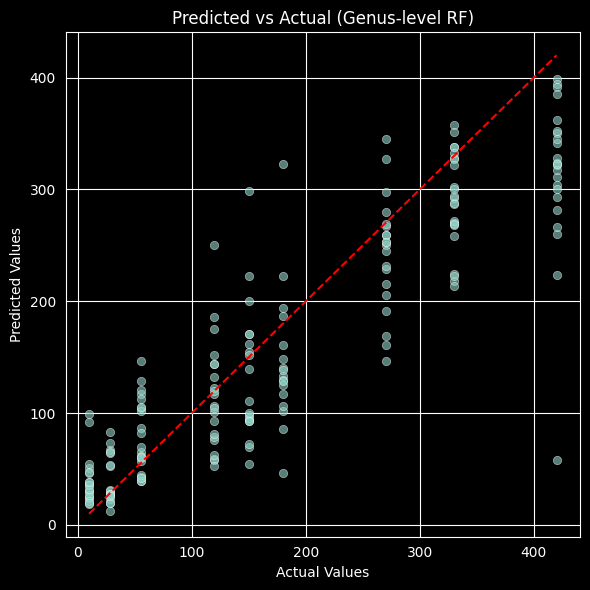

In [7]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat_best, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level RF)")
plt.tight_layout()
plt.show()

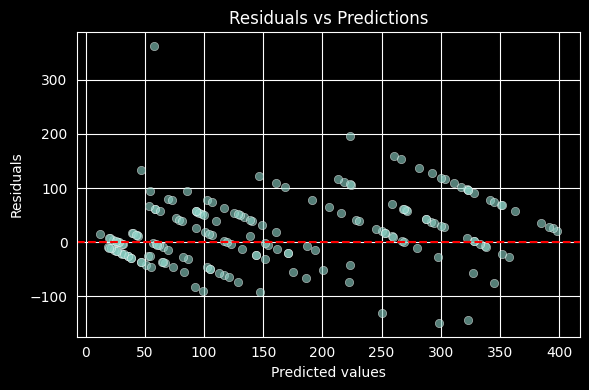

In [8]:
residuals = Y_test - yhat_best

plt.figure(figsize=(6,4))
sns.scatterplot(x=yhat_best, y=residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")

plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.tight_layout()
plt.show()

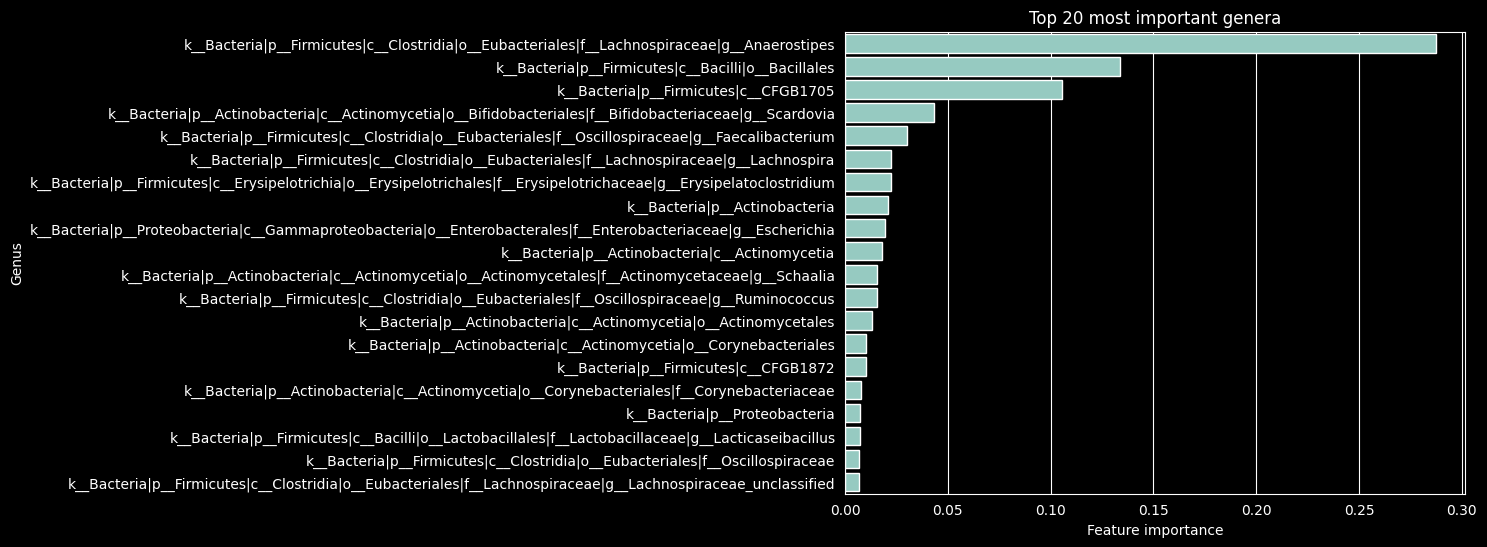

In [9]:
importances = pd.Series(
    best_rf.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(top_n),
    y=importances.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera")
plt.tight_layout()
plt.show()

In [10]:
st = SuperTree(
    best_rf,
    X_train_genus,
    Y_train
)

st.show_tree(which_tree=0)

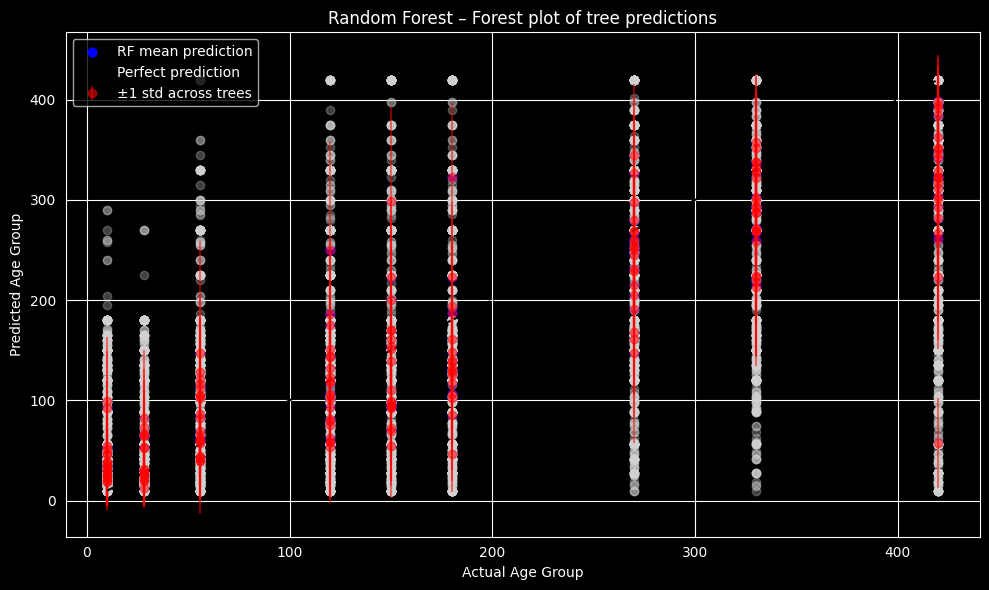

In [11]:
# get predictions from each tree on the test set
all_tree_preds = np.array([tree.predict(X_test_genus) for tree in best_rf.estimators_])

# compute the mean prediction (Random Forest final prediction)
rf_pred = all_tree_preds.mean(axis=0)

# compute standard deviation per sample (uncertainty)
rf_std = all_tree_preds.std(axis=0)

plt.figure(figsize=(10,6))

# plot all tree predictions (semi-transparent lines)
for i in range(all_tree_preds.shape[0]):
    plt.plot(Y_test.values, all_tree_preds[i], 'o', color='lightgray', alpha=0.3)

# plot Random Forest mean prediction
plt.scatter(Y_test, rf_pred, color='blue', label='RF mean prediction', s=40)

plt.errorbar(Y_test, rf_pred, yerr=rf_std, fmt='o', color='red', alpha=0.5, label='±1 std across trees')

plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color='black', linestyle='--', label='Perfect prediction')

plt.xlabel("Actual Age Group")
plt.ylabel("Predicted Age Group")
plt.title("Random Forest – Forest plot of tree predictions")
plt.legend()
plt.tight_layout()
plt.show()


## Advanced Visualisations

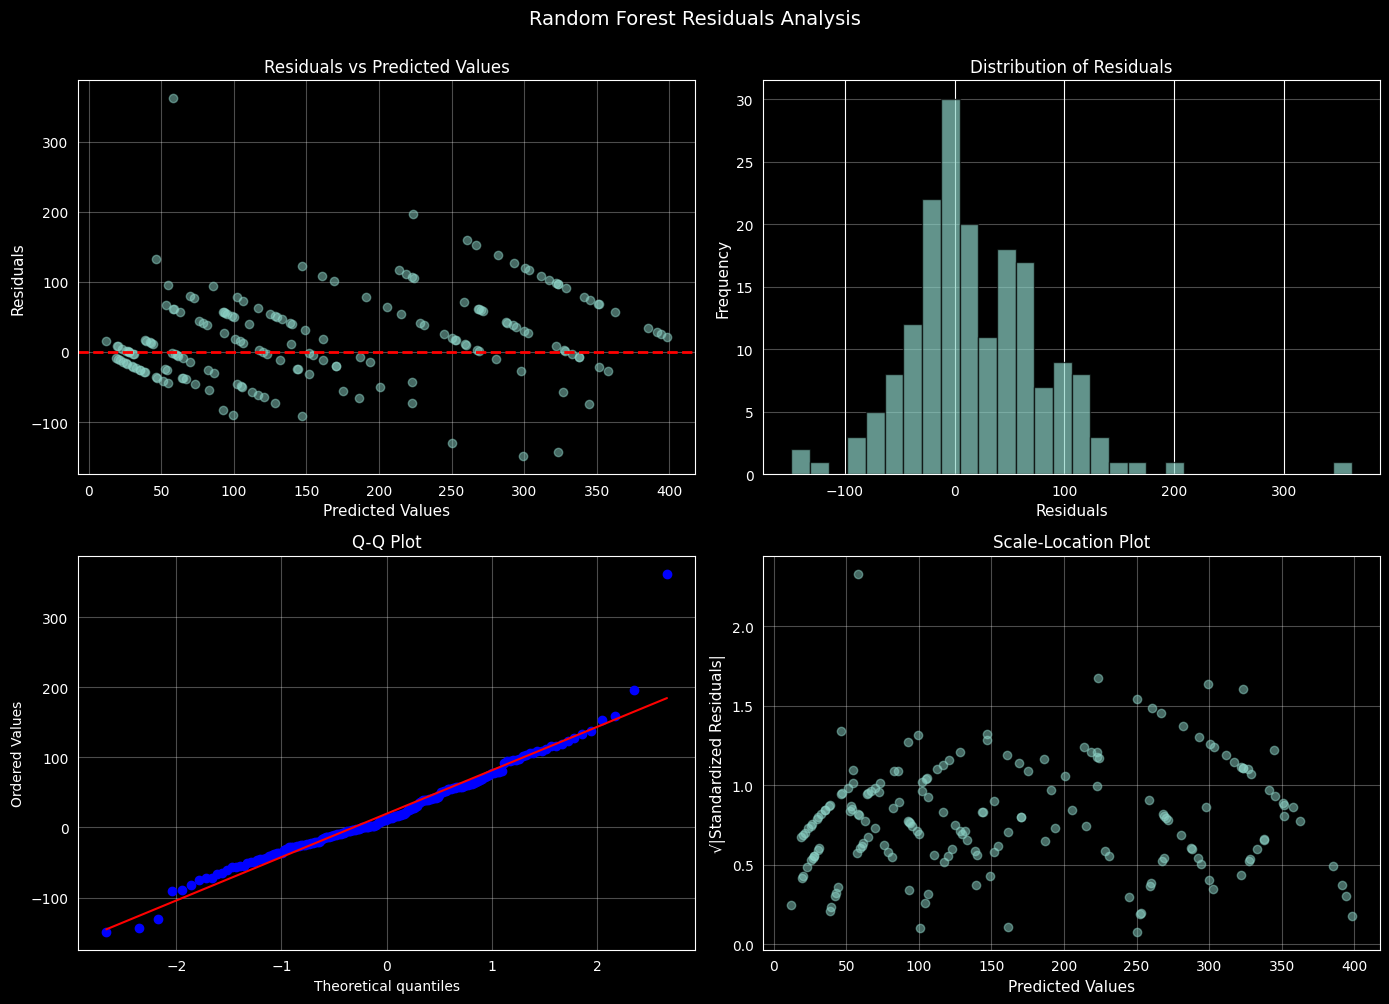


Residual Statistics:
  Mean: 19.6631
  Std Dev: 62.9876
  Min: -148.8879
  Max: 362.1237
  MAE: 48.0104


In [12]:
plot_residuals_analysis(Y_test, yhat_best, title="Random Forest Residuals Analysis")

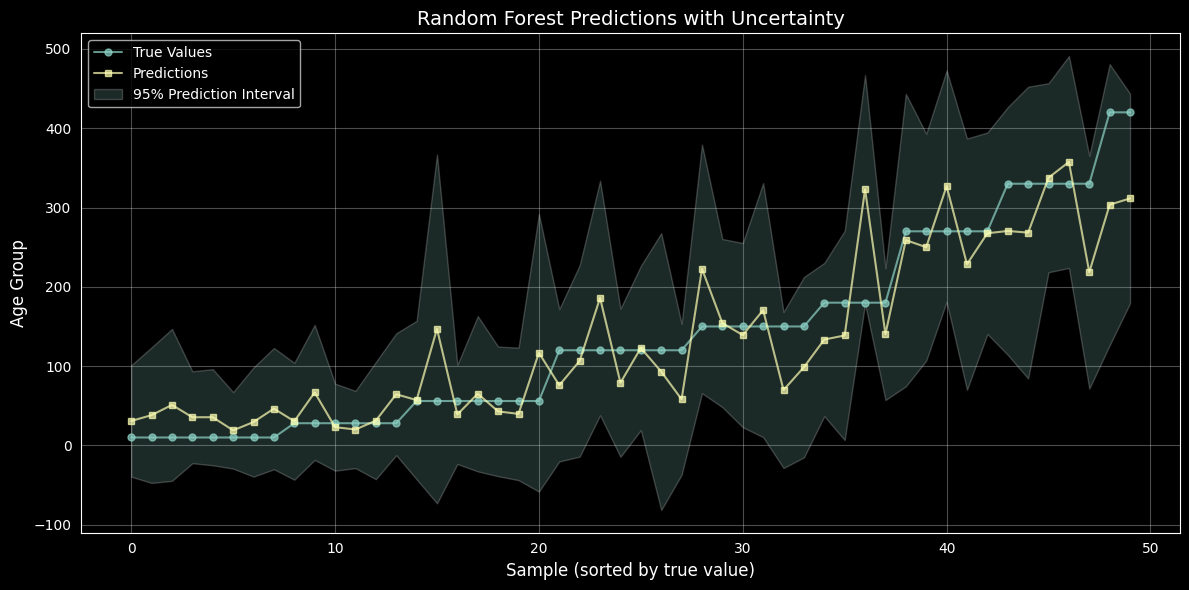

In [13]:
# Prediction intervals (showing uncertainty from individual trees)
plot_prediction_intervals(
    Y_test,
    yhat_best,
    prediction_std=rf_std,
    sample_indices=range(50),  # Show first 50 samples
    title="Random Forest Predictions with Uncertainty"
)

In [14]:
# Learning curves to check for overfitting

plot_learning_curves(
    best_rf,
    X_train_genus,
    Y_train,
    cv_folds=7,
    title="Random Forest Learning Curves (Genus Level)"
)

In [15]:
#Cleaning up RAM by removing the stored variables

#del X_train_genus
#del X_test_genus
#del Y_train
#del Y_test